In [6]:
from importlib import reload
import numpy as np
import torch
import torch_geometric
from sklearn.metrics import balanced_accuracy_score, accuracy_score, precision_score, recall_score, fbeta_score, precision_recall_curve, average_precision_score
from torch.nn import functional as F
import matplotlib.pyplot as plt

import criterions
reload(criterions)
from criterions import ClassBalancedLoss

import data
reload(data)
from torch_geometric.data import Data

import train
reload(train)
from train import train_GAT_GraphSVX_foroptuna, train_GraphSAGE_foroptuna

In [2]:

hyperparameters = {'hidden_channels': 15,
                   'num_heads': 3,
                    'dropout': 0.2,
                    'lr': 0.002,
                    'epochs': 1000,
                    'beta': 0.9999, 
                    'seed':42}

model_name = 'GraphSAGE'
dataset_name ='100K_accts_EASY25'

model, traindata, testdata, feature_names, target_names, running_train_loss, running_test_loss, accuracy = train_GraphSAGE_foroptuna(dataset_name, hyperparameters, verbose = True)

30
30
traindata.x.shape[1]:  29
testdata.x.shape[1]:  29
epoch: 1, train_loss: 0.7346, test_loss: 0.7287188172340393, accuracy: 0.2372, balanced_accuracy: 0.5012, precision: 0.2328, recall: 0.9945, f0.9999: 0.3772
epoch: 10, train_loss: 0.6690, test_loss: 0.7045006155967712, accuracy: 0.2866, balanced_accuracy: 0.5237, precision: 0.2414, recall: 0.9664, f0.9999: 0.3863
epoch: 20, train_loss: 0.6196, test_loss: 0.6382396817207336, accuracy: 0.6260, balanced_accuracy: 0.5834, precision: 0.3115, recall: 0.5038, f0.9999: 0.3849
epoch: 30, train_loss: 0.5833, test_loss: 0.5768795013427734, accuracy: 0.7319, balanced_accuracy: 0.5665, precision: 0.3849, recall: 0.2576, f0.9999: 0.3087
epoch: 40, train_loss: 0.5535, test_loss: 0.5356500744819641, accuracy: 0.7613, balanced_accuracy: 0.5519, precision: 0.4605, recall: 0.1607, f0.9999: 0.2383
epoch: 50, train_loss: 0.5280, test_loss: 0.5070419311523438, accuracy: 0.7720, balanced_accuracy: 0.5446, precision: 0.5425, recall: 0.1198, f0.9999: 0.1

In [15]:
# This worked pretty well with 100 tolerance in early stopping
# hyperparameters = {'hidden_channels': 10,
#                    'num_heads': 2,
#                     'dropout': 0.15,
#                     'lr': 0.002,
#                     'epochs': 1000,
#                     'beta': 0.99991,
#                     'seed':1}

hyperparameters = {'hidden_channels': 20,
                   'num_heads': 3,
                    'dropout': 0.3,
                    'lr': 0.001,
                    'epochs': 1000,
                    'beta': 0.9999,
                    'seed':1}

model_name = 'GAT'
dataset_name = '100K_accts_EASY25'

model, traindata, testdata, feature_names, target_names, running_train_loss, running_test_loss, accuracy, fbeta = train_GAT_GraphSVX_foroptuna(dataset_name, hyperparameters, verbose = True)

Using device: cuda
Double check which dataset is being used.
number of samples per classes (train) = [76743, 23257]
number of samples per classes (val) = [76708, 23213]
Starting training with 1000 epochs.
epoch: 10, train_loss: 0.6508, val_loss: 0.6030, accuracy: 0.7180, precision: 0.1784, recall: 0.0594, fbeta: 0.0891
epoch: 20, train_loss: 0.6143, val_loss: 0.5637, accuracy: 0.7553, precision: 0.1584, recall: 0.0123, fbeta: 0.0229
epoch: 30, train_loss: 0.5755, val_loss: 0.5357, accuracy: 0.7660, precision: 0.2878, recall: 0.0050, fbeta: 0.0098
epoch: 40, train_loss: 0.5500, val_loss: 0.5191, accuracy: 0.7677, precision: 0.4954, recall: 0.0046, fbeta: 0.0091
epoch: 50, train_loss: 0.5320, val_loss: 0.5068, accuracy: 0.7678, precision: 0.5248, recall: 0.0073, fbeta: 0.0144
epoch: 60, train_loss: 0.5171, val_loss: 0.4911, accuracy: 0.7683, precision: 0.5333, recall: 0.0197, fbeta: 0.0380
epoch: 70, train_loss: 0.5049, val_loss: 0.4777, accuracy: 0.7705, precision: 0.5781, recall: 0.044

In [21]:
# Save the model

torch.save({
    'model_state_dict': model.state_dict(),
    'hyperparameters': hyperparameters,
    'traindata': traindata,
    'testdata': testdata,
    'feature_names': feature_names,
    'target_names': target_names,
    'running_train_loss': running_train_loss,
    'running_test_loss': running_test_loss,
    'accuracy': accuracy
}, f'trained_models_olddata_90overlap/{model_name}_{dataset_name}.pth')

In [18]:
print(f'Shaple of traindata.x: {traindata.x.shape}')

Shaple of traindata.x: torch.Size([100000, 31])


In [16]:
from sklearn.metrics import confusion_matrix
import numpy as np

model.eval()
with torch.no_grad():
    out = model.forward(testdata.x, testdata.edge_index)
    out = F.softmax(out, dim=1)
    y_pred = out.cpu().numpy().argmax(axis=1)
    y_true = testdata.y.cpu().numpy()
    cm = confusion_matrix(y_true, y_pred)
    print(cm)

[[72398  4310]
 [11679 11534]]


0.2720272658419591
Average Precision = 0.6977729247410805


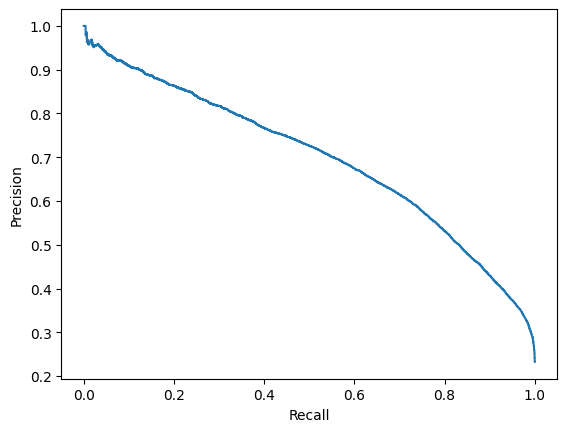

In [19]:
FPpercent = cm[0,1] / (cm[1,1] + cm[0,1])
print(FPpercent)

# Todo: precision recall curve
precision, recall, thresholds = precision_recall_curve(y_true, out[:,1].cpu().numpy())
average_precision = average_precision_score(y_true, out[:,1].cpu().numpy())

print(f'Average Precision = {average_precision}')

# print(thresholds)
# print(len(thresholds))

plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

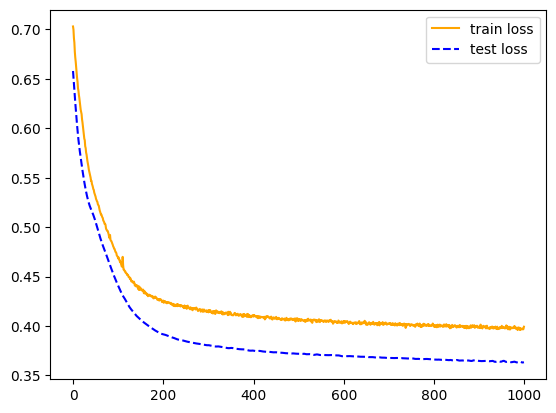

In [20]:
plt.plot(running_train_loss, label='train loss', color='orange')
plt.plot(running_test_loss, label='test loss', color='blue', linestyle='--')
#plt.axvline(x=first_stop, color='red', linestyle='--')
plt.legend(['train loss', 'test loss'])
plt.show()

# Optuna

In [39]:
import optuna
import joblib

# Best result found:
# acc = 0.81
# 'hidden_channels': 40, 'dropout': 0.12494751056760699, 'lr': 0.007997224211163154, 'epochs': 4200, 'beta': 0.9166784968106625

# hyperparameters = {'hidden_channels': 10,
#                    'num_heads': 2,
#                     'dropout': 0.15,
#                     'lr': 0.002,
#                     'epochs': 1000,
#                     'beta': 0.99991,
#                     'seed':1}

def objective(trial):
    hyperparameters = {'hidden_channels': trial.suggest_int('hidden_channels', 10, 15, step=5),
                   'num_heads': 3,
                    'dropout': trial.suggest_float('dropout', 0.1, 0.2),
                    'lr': trial.suggest_float('lr', 0.001, 0.003),
                    'epochs': 1000,
                    'beta': trial.suggest_float('beta', 0.9999, 0.99992)}
    
    model, _, _, _, _, _, _, _, fbeta = train_GAT_GraphSVX_foroptuna(dataset_name, hyperparameters, verbose = False)
    
    trial.set_user_attr('model', model)
    
    return fbeta

best_model = [None]
def save_best_model_callback(study, trial):
    if study.best_trial == trial:
        best_model[0] = trial.user_attrs['model']

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 100, callbacks=[save_best_model_callback])

best_model_path = 'best_model.pkl'
joblib.dump(best_model[0], best_model_path)
print(f"Best model saved to {best_model_path}")

[I 2024-05-21 08:52:05,607] A new study created in memory with name: no-name-c1c1649f-15a2-4afd-ad89-11d9e33078dd


Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 08:52:49,550] Trial 0 finished with value: 0.062135078763573146 and parameters: {'hidden_channels': 15, 'dropout': 0.1771173173400492, 'lr': 0.0022922003414399443, 'beta': 0.9999142060175958}. Best is trial 0 with value: 0.062135078763573146.


Stopping training early at 257/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 08:53:43,582] Trial 1 finished with value: 0.0846668205654674 and parameters: {'hidden_channels': 15, 'dropout': 0.1082851302015779, 'lr': 0.0023901487461726817, 'beta': 0.9999070545418475}. Best is trial 1 with value: 0.0846668205654674.


Stopping training early at 279/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 08:54:48,340] Trial 2 finished with value: 0.22468871756798312 and parameters: {'hidden_channels': 15, 'dropout': 0.10138265737027326, 'lr': 0.0018567937169066762, 'beta': 0.9999129953445728}. Best is trial 2 with value: 0.22468871756798312.


Stopping training early at 310/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 08:56:34,774] Trial 3 finished with value: 0.3863201503958883 and parameters: {'hidden_channels': 10, 'dropout': 0.19613515436086337, 'lr': 0.0016705509069005011, 'beta': 0.9999060366824917}. Best is trial 3 with value: 0.3863201503958883.


Stopping training early at 562/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 08:59:23,434] Trial 4 finished with value: 0.2972487338086366 and parameters: {'hidden_channels': 10, 'dropout': 0.18068531975927785, 'lr': 0.0020115026837467746, 'beta': 0.9999171970300396}. Best is trial 3 with value: 0.3863201503958883.


Stopping training early at 776/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 09:00:26,858] Trial 5 finished with value: 0.02869992067427494 and parameters: {'hidden_channels': 15, 'dropout': 0.11085153936160456, 'lr': 0.0013954317132210993, 'beta': 0.9999100148409589}. Best is trial 3 with value: 0.3863201503958883.


Stopping training early at 269/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 09:01:27,855] Trial 6 finished with value: 0.33621738048779404 and parameters: {'hidden_channels': 15, 'dropout': 0.129775760802638, 'lr': 0.0028468006644833065, 'beta': 0.999913351142296}. Best is trial 3 with value: 0.3863201503958883.


Stopping training early at 263/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 09:02:52,204] Trial 7 finished with value: 0.3861419507700766 and parameters: {'hidden_channels': 10, 'dropout': 0.12653037300042697, 'lr': 0.002872300131613425, 'beta': 0.9999055363499246}. Best is trial 3 with value: 0.3863201503958883.


Stopping training early at 404/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 09:03:59,433] Trial 8 finished with value: 0.016789012036659223 and parameters: {'hidden_channels': 15, 'dropout': 0.15221302433697667, 'lr': 0.0010947588001680904, 'beta': 0.9999072508132705}. Best is trial 3 with value: 0.3863201503958883.


Stopping training early at 299/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 09:05:17,008] Trial 9 finished with value: 0.37074291149614425 and parameters: {'hidden_channels': 10, 'dropout': 0.10133559336213595, 'lr': 0.002432378118527853, 'beta': 0.999913365729136}. Best is trial 3 with value: 0.3863201503958883.


Stopping training early at 363/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 09:07:03,760] Trial 10 finished with value: 0.29669435488853513 and parameters: {'hidden_channels': 10, 'dropout': 0.19952069438970949, 'lr': 0.0015943600876454915, 'beta': 0.9999032105871718}. Best is trial 3 with value: 0.3863201503958883.


Stopping training early at 478/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 09:08:14,448] Trial 11 finished with value: 0.10489162286906101 and parameters: {'hidden_channels': 10, 'dropout': 0.14001654576182596, 'lr': 0.002990072114050513, 'beta': 0.9999003941128191}. Best is trial 3 with value: 0.3863201503958883.


Stopping training early at 333/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 09:09:56,046] Trial 12 finished with value: 0.370571283885562 and parameters: {'hidden_channels': 10, 'dropout': 0.16092960390667105, 'lr': 0.0017483278154260726, 'beta': 0.9999052410600648}. Best is trial 3 with value: 0.3863201503958883.


Stopping training early at 484/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 09:11:27,017] Trial 13 finished with value: 0.39831711691707333 and parameters: {'hidden_channels': 10, 'dropout': 0.1290882225031532, 'lr': 0.002687881348550537, 'beta': 0.9999022455161285}. Best is trial 13 with value: 0.39831711691707333.


Stopping training early at 428/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 09:12:17,160] Trial 14 finished with value: 0.015262840454393313 and parameters: {'hidden_channels': 10, 'dropout': 0.19488811832083108, 'lr': 0.0020707308812868913, 'beta': 0.9999004179307486}. Best is trial 13 with value: 0.39831711691707333.


Stopping training early at 238/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 09:15:38,922] Trial 15 finished with value: 0.41949721577879523 and parameters: {'hidden_channels': 10, 'dropout': 0.16812835987118724, 'lr': 0.0013440696757133367, 'beta': 0.9999032474422146}. Best is trial 15 with value: 0.41949721577879523.


Stopping training early at 961/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 09:16:22,380] Trial 16 finished with value: 0.18108214383027885 and parameters: {'hidden_channels': 10, 'dropout': 0.16603859841547197, 'lr': 0.0011071459449810226, 'beta': 0.9999028344866334}. Best is trial 15 with value: 0.41949721577879523.


Stopping training early at 189/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 09:19:53,962] Trial 17 finished with value: 0.3810900814619459 and parameters: {'hidden_channels': 10, 'dropout': 0.13934763554651539, 'lr': 0.001360725497846727, 'beta': 0.999909517016483}. Best is trial 15 with value: 0.41949721577879523.


Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 09:21:26,051] Trial 18 finished with value: 0.332279050914988 and parameters: {'hidden_channels': 10, 'dropout': 0.1496134787420746, 'lr': 0.0026404697009574916, 'beta': 0.9999029457872026}. Best is trial 15 with value: 0.41949721577879523.


Stopping training early at 433/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.
Stopping training early at 397/1000 epochs.
Finished training.


[I 2024-05-21 09:22:49,211] Trial 19 finished with value: 0.2119266826248259 and parameters: {'hidden_channels': 10, 'dropout': 0.11954824209377914, 'lr': 0.002157941850447872, 'beta': 0.9999094752633215}. Best is trial 15 with value: 0.41949721577879523.


Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 09:24:48,699] Trial 20 finished with value: 0.4091242186429985 and parameters: {'hidden_channels': 10, 'dropout': 0.17526025581954033, 'lr': 0.002585801366302999, 'beta': 0.9999018509452259}. Best is trial 15 with value: 0.41949721577879523.


Stopping training early at 567/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 09:26:33,295] Trial 21 finished with value: 0.31638342514676954 and parameters: {'hidden_channels': 10, 'dropout': 0.17859627029913103, 'lr': 0.0026467804530885836, 'beta': 0.9999016717896186}. Best is trial 15 with value: 0.41949721577879523.


Stopping training early at 475/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 09:28:01,532] Trial 22 finished with value: 0.2535778116337452 and parameters: {'hidden_channels': 10, 'dropout': 0.16463275064657645, 'lr': 0.0025754589997946725, 'beta': 0.9999040821632957}. Best is trial 15 with value: 0.41949721577879523.


Stopping training early at 426/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 09:29:23,277] Trial 23 finished with value: 0.3594344664839966 and parameters: {'hidden_channels': 10, 'dropout': 0.18517557870188228, 'lr': 0.0022103535900563805, 'beta': 0.9999016035058348}. Best is trial 15 with value: 0.41949721577879523.


Stopping training early at 367/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 09:32:36,153] Trial 24 finished with value: 0.4087269104614581 and parameters: {'hidden_channels': 10, 'dropout': 0.16965695831372082, 'lr': 0.0024973055642571653, 'beta': 0.9999000011690358}. Best is trial 15 with value: 0.41949721577879523.


Stopping training early at 959/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 09:34:11,535] Trial 25 finished with value: 0.36921564180234817 and parameters: {'hidden_channels': 10, 'dropout': 0.17029259274522038, 'lr': 0.002468824258551813, 'beta': 0.9999000697301392}. Best is trial 15 with value: 0.41949721577879523.


Stopping training early at 469/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 09:36:29,406] Trial 26 finished with value: 0.2546172893732845 and parameters: {'hidden_channels': 10, 'dropout': 0.15455460932599333, 'lr': 0.0019074634756526493, 'beta': 0.9999042171436279}. Best is trial 15 with value: 0.41949721577879523.


Stopping training early at 688/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 09:38:57,683] Trial 27 finished with value: 0.41669601149407776 and parameters: {'hidden_channels': 10, 'dropout': 0.18999754581501185, 'lr': 0.0028232114783763307, 'beta': 0.9999080053522627}. Best is trial 15 with value: 0.41949721577879523.


Stopping training early at 767/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 09:41:12,734] Trial 28 finished with value: 0.3910989648262882 and parameters: {'hidden_channels': 10, 'dropout': 0.1896345918243251, 'lr': 0.002795734952924848, 'beta': 0.9999196096990997}. Best is trial 15 with value: 0.41949721577879523.


Stopping training early at 701/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 09:43:58,563] Trial 29 finished with value: 0.3146143050978923 and parameters: {'hidden_channels': 15, 'dropout': 0.18597435630781173, 'lr': 0.0014266170629385838, 'beta': 0.9999111575164805}. Best is trial 15 with value: 0.41949721577879523.


Stopping training early at 708/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 09:45:16,967] Trial 30 finished with value: 0.35019425098624996 and parameters: {'hidden_channels': 10, 'dropout': 0.17449752771663865, 'lr': 0.002292093744129431, 'beta': 0.9999071824555607}. Best is trial 15 with value: 0.41949721577879523.


Stopping training early at 347/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 09:46:48,614] Trial 31 finished with value: 0.13138718172127853 and parameters: {'hidden_channels': 10, 'dropout': 0.1728405370036523, 'lr': 0.0025045535871017484, 'beta': 0.9999015507662763}. Best is trial 15 with value: 0.41949721577879523.


Stopping training early at 425/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 09:49:02,624] Trial 32 finished with value: 0.3512893034629771 and parameters: {'hidden_channels': 10, 'dropout': 0.15888601599553326, 'lr': 0.002322643515717811, 'beta': 0.9999083451948786}. Best is trial 15 with value: 0.41949721577879523.


Stopping training early at 675/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 09:51:04,828] Trial 33 finished with value: 0.376971375926657 and parameters: {'hidden_channels': 10, 'dropout': 0.18106135279343016, 'lr': 0.002976503007335832, 'beta': 0.9999046088966984}. Best is trial 15 with value: 0.41949721577879523.


Stopping training early at 611/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 09:52:46,758] Trial 34 finished with value: 0.3493623291171595 and parameters: {'hidden_channels': 10, 'dropout': 0.1904625525895987, 'lr': 0.0027609186915898126, 'beta': 0.9999036665171941}. Best is trial 15 with value: 0.41949721577879523.


Stopping training early at 494/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 09:54:03,339] Trial 35 finished with value: 0.10492904075179554 and parameters: {'hidden_channels': 15, 'dropout': 0.16615076976413098, 'lr': 0.002524065819236932, 'beta': 0.9999062393134729}. Best is trial 15 with value: 0.41949721577879523.


Stopping training early at 344/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 09:56:00,135] Trial 36 finished with value: 0.32467222328981976 and parameters: {'hidden_channels': 10, 'dropout': 0.1709058574109286, 'lr': 0.002344971731729856, 'beta': 0.9999155618692223}. Best is trial 15 with value: 0.41949721577879523.


Stopping training early at 537/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 09:58:20,342] Trial 37 finished with value: 0.3117541925521215 and parameters: {'hidden_channels': 10, 'dropout': 0.1825264867611841, 'lr': 0.0027304937827969445, 'beta': 0.9999010217485756}. Best is trial 15 with value: 0.41949721577879523.


Stopping training early at 718/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 09:59:31,143] Trial 38 finished with value: 0.051362629995025465 and parameters: {'hidden_channels': 15, 'dropout': 0.1774615294836055, 'lr': 0.001006729490276836, 'beta': 0.9999114325319189}. Best is trial 15 with value: 0.41949721577879523.


Stopping training early at 339/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 10:00:13,041] Trial 39 finished with value: 0.13982067069262594 and parameters: {'hidden_channels': 10, 'dropout': 0.14765874119112515, 'lr': 0.0012791282771234009, 'beta': 0.999902361431099}. Best is trial 15 with value: 0.41949721577879523.


Stopping training early at 203/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 10:00:38,594] Trial 40 finished with value: 0.0 and parameters: {'hidden_channels': 10, 'dropout': 0.19368770096411206, 'lr': 0.0018598087163491203, 'beta': 0.9999085519243267}. Best is trial 15 with value: 0.41949721577879523.


Stopping training early at 113/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 10:02:27,232] Trial 41 finished with value: 0.3345115404828266 and parameters: {'hidden_channels': 10, 'dropout': 0.1382574231433624, 'lr': 0.00266426721370404, 'beta': 0.9999022915696877}. Best is trial 15 with value: 0.41949721577879523.


Stopping training early at 525/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 10:03:29,246] Trial 42 finished with value: 0.09753397780836552 and parameters: {'hidden_channels': 10, 'dropout': 0.12252759903146535, 'lr': 0.0028903258826907933, 'beta': 0.9999049315199033}. Best is trial 15 with value: 0.41949721577879523.


Stopping training early at 303/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 10:04:16,780] Trial 43 finished with value: 0.1175319627421005 and parameters: {'hidden_channels': 10, 'dropout': 0.11082984686185406, 'lr': 0.002584489781043728, 'beta': 0.9999063761743979}. Best is trial 15 with value: 0.41949721577879523.


Stopping training early at 225/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 10:05:27,659] Trial 44 finished with value: 0.17819764456495435 and parameters: {'hidden_channels': 10, 'dropout': 0.14429895348133312, 'lr': 0.0028722441052702547, 'beta': 0.9999010928306905}. Best is trial 15 with value: 0.41949721577879523.


Stopping training early at 345/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 10:07:59,002] Trial 45 finished with value: 0.3945535815777825 and parameters: {'hidden_channels': 10, 'dropout': 0.1591004698704557, 'lr': 0.0015778803679806182, 'beta': 0.9999000261084475}. Best is trial 15 with value: 0.41949721577879523.


Stopping training early at 810/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 10:09:07,402] Trial 46 finished with value: 0.17421433021427946 and parameters: {'hidden_channels': 10, 'dropout': 0.16758787836372885, 'lr': 0.002417803238251162, 'beta': 0.9999034462807334}. Best is trial 15 with value: 0.41949721577879523.


Stopping training early at 345/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 10:10:37,390] Trial 47 finished with value: 0.28482212083618613 and parameters: {'hidden_channels': 10, 'dropout': 0.13166815273743085, 'lr': 0.0027248410160450693, 'beta': 0.9999022094996713}. Best is trial 15 with value: 0.41949721577879523.


Stopping training early at 462/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 10:13:02,975] Trial 48 finished with value: 0.30394425683606263 and parameters: {'hidden_channels': 15, 'dropout': 0.19811155362127686, 'lr': 0.001997981252849049, 'beta': 0.9999008351804413}. Best is trial 15 with value: 0.41949721577879523.


Stopping training early at 709/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 10:14:54,342] Trial 49 finished with value: 0.24478199856650115 and parameters: {'hidden_channels': 10, 'dropout': 0.17557617475620377, 'lr': 0.002916972708933776, 'beta': 0.9999057483040508}. Best is trial 15 with value: 0.41949721577879523.


Stopping training early at 569/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 10:15:59,552] Trial 50 finished with value: 0.29243877479409985 and parameters: {'hidden_channels': 10, 'dropout': 0.18831834261699443, 'lr': 0.002216602565080839, 'beta': 0.9999080212649939}. Best is trial 15 with value: 0.41949721577879523.


Stopping training early at 324/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 10:19:09,270] Trial 51 finished with value: 0.3294070022480661 and parameters: {'hidden_channels': 10, 'dropout': 0.16037285323935357, 'lr': 0.0016196404260417413, 'beta': 0.999900532927537}. Best is trial 15 with value: 0.41949721577879523.


Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 10:21:57,639] Trial 52 finished with value: 0.34576292372171097 and parameters: {'hidden_channels': 10, 'dropout': 0.15512034600355654, 'lr': 0.0014567448435267695, 'beta': 0.9999000883890375}. Best is trial 15 with value: 0.41949721577879523.


Stopping training early at 866/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 10:24:06,936] Trial 53 finished with value: 0.3672135053523765 and parameters: {'hidden_channels': 10, 'dropout': 0.162587804298373, 'lr': 0.0017451273850900922, 'beta': 0.9999025212428548}. Best is trial 15 with value: 0.41949721577879523.


Stopping training early at 627/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 10:26:17,226] Trial 54 finished with value: 0.35093623134815016 and parameters: {'hidden_channels': 10, 'dropout': 0.11660787108600998, 'lr': 0.0012571253867005034, 'beta': 0.999901662162921}. Best is trial 15 with value: 0.41949721577879523.


Stopping training early at 646/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 10:26:58,586] Trial 55 finished with value: 0.2172432076344465 and parameters: {'hidden_channels': 10, 'dropout': 0.16905358119087685, 'lr': 0.0012028721669601816, 'beta': 0.9999035039388378}. Best is trial 15 with value: 0.41949721577879523.


Stopping training early at 209/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 10:29:35,602] Trial 56 finished with value: 0.2126131900162645 and parameters: {'hidden_channels': 10, 'dropout': 0.15614863126368791, 'lr': 0.0014852223248521983, 'beta': 0.9999011874798652}. Best is trial 15 with value: 0.41949721577879523.


Stopping training early at 795/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 10:30:48,696] Trial 57 finished with value: 0.26007345217033434 and parameters: {'hidden_channels': 10, 'dropout': 0.1639958643883153, 'lr': 0.0015414409982722208, 'beta': 0.9999029824678837}. Best is trial 15 with value: 0.41949721577879523.


Stopping training early at 363/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 10:31:11,615] Trial 58 finished with value: 0.11884842077042261 and parameters: {'hidden_channels': 10, 'dropout': 0.1347711679156435, 'lr': 0.0028165418439485704, 'beta': 0.9999000290678393}. Best is trial 15 with value: 0.41949721577879523.


Stopping training early at 100/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 10:33:21,866] Trial 59 finished with value: 0.37866497148458905 and parameters: {'hidden_channels': 10, 'dropout': 0.1454831094039901, 'lr': 0.002573815369989143, 'beta': 0.9999018137800161}. Best is trial 15 with value: 0.41949721577879523.


Stopping training early at 666/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 10:34:59,640] Trial 60 finished with value: 0.341911228527571 and parameters: {'hidden_channels': 10, 'dropout': 0.15027771841478627, 'lr': 0.0017225147245779591, 'beta': 0.9999041878519144}. Best is trial 15 with value: 0.41949721577879523.


Stopping training early at 507/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 10:36:40,177] Trial 61 finished with value: 0.4043884817406995 and parameters: {'hidden_channels': 10, 'dropout': 0.18397226612476775, 'lr': 0.0027824089996828, 'beta': 0.9999194059748251}. Best is trial 15 with value: 0.41949721577879523.


Stopping training early at 507/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 10:37:36,266] Trial 62 finished with value: 0.268427176475192 and parameters: {'hidden_channels': 10, 'dropout': 0.17901382059815743, 'lr': 0.002665055857500677, 'beta': 0.9999189681515481}. Best is trial 15 with value: 0.41949721577879523.


Stopping training early at 270/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 10:40:50,859] Trial 63 finished with value: 0.345284981936689 and parameters: {'hidden_channels': 10, 'dropout': 0.18446201862245867, 'lr': 0.001355037611067987, 'beta': 0.99991541706332}. Best is trial 15 with value: 0.41949721577879523.


Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 10:42:27,219] Trial 64 finished with value: 0.2527717453866791 and parameters: {'hidden_channels': 10, 'dropout': 0.19343777286735026, 'lr': 0.002712738688713618, 'beta': 0.9999122350251354}. Best is trial 15 with value: 0.41949721577879523.


Stopping training early at 491/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 10:42:55,074] Trial 65 finished with value: 0.15595912404113163 and parameters: {'hidden_channels': 10, 'dropout': 0.17259837537890696, 'lr': 0.0028100356391748647, 'beta': 0.9999102843469574}. Best is trial 15 with value: 0.41949721577879523.


Stopping training early at 124/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 10:43:43,870] Trial 66 finished with value: 0.2290340368103709 and parameters: {'hidden_channels': 10, 'dropout': 0.15788902118694176, 'lr': 0.002615744379396554, 'beta': 0.9999178826143068}. Best is trial 15 with value: 0.41949721577879523.


Stopping training early at 252/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 10:45:40,968] Trial 67 finished with value: 0.2226708771142374 and parameters: {'hidden_channels': 10, 'dropout': 0.18131543716246007, 'lr': 0.002964091186625739, 'beta': 0.9999136549282927}. Best is trial 15 with value: 0.41949721577879523.


Stopping training early at 607/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 10:48:21,674] Trial 68 finished with value: 0.36052159465235556 and parameters: {'hidden_channels': 10, 'dropout': 0.18842409364343302, 'lr': 0.0025363406246614573, 'beta': 0.9999006356182457}. Best is trial 15 with value: 0.41949721577879523.


Stopping training early at 815/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 10:49:25,701] Trial 69 finished with value: 0.3667957999262676 and parameters: {'hidden_channels': 10, 'dropout': 0.17621581886425058, 'lr': 0.0024272301714713907, 'beta': 0.9999151676187698}. Best is trial 15 with value: 0.41949721577879523.


Stopping training early at 314/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 10:51:38,441] Trial 70 finished with value: 0.3894338188143221 and parameters: {'hidden_channels': 10, 'dropout': 0.10570453058368484, 'lr': 0.0024748964175436506, 'beta': 0.9999162315679698}. Best is trial 15 with value: 0.41949721577879523.


Stopping training early at 671/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 10:52:45,731] Trial 71 finished with value: 0.3491140107962468 and parameters: {'hidden_channels': 10, 'dropout': 0.19101379347461792, 'lr': 0.0027730557525744294, 'beta': 0.999919471924592}. Best is trial 15 with value: 0.41949721577879523.


Stopping training early at 331/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 10:54:03,690] Trial 72 finished with value: 0.35262239234194354 and parameters: {'hidden_channels': 10, 'dropout': 0.18361859501347952, 'lr': 0.00283322862065446, 'beta': 0.9999178469131259}. Best is trial 15 with value: 0.41949721577879523.


Stopping training early at 383/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 10:54:55,991] Trial 73 finished with value: 0.2571131026239006 and parameters: {'hidden_channels': 10, 'dropout': 0.18812299207937516, 'lr': 0.002939342088741862, 'beta': 0.9999196962485825}. Best is trial 15 with value: 0.41949721577879523.


Stopping training early at 252/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 10:57:19,131] Trial 74 finished with value: 0.2618807405983784 and parameters: {'hidden_channels': 10, 'dropout': 0.19705620608521213, 'lr': 0.0027026100286264825, 'beta': 0.999919192976594}. Best is trial 15 with value: 0.41949721577879523.


Stopping training early at 719/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 11:00:34,444] Trial 75 finished with value: 0.3759654015644139 and parameters: {'hidden_channels': 10, 'dropout': 0.17945941177550512, 'lr': 0.0027926942276138606, 'beta': 0.9999173314801256}. Best is trial 15 with value: 0.41949721577879523.


Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 11:01:59,865] Trial 76 finished with value: 0.3885670863481719 and parameters: {'hidden_channels': 10, 'dropout': 0.1726933068701686, 'lr': 0.0029956436959878846, 'beta': 0.9999199846650043}. Best is trial 15 with value: 0.41949721577879523.


Stopping training early at 466/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 11:03:48,539] Trial 77 finished with value: 0.35096372471092036 and parameters: {'hidden_channels': 10, 'dropout': 0.16900387687564886, 'lr': 0.002875030866346419, 'beta': 0.999918590928411}. Best is trial 15 with value: 0.41949721577879523.


Stopping training early at 568/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 11:04:34,248] Trial 78 finished with value: 0.005370681747395824 and parameters: {'hidden_channels': 10, 'dropout': 0.16603114740180153, 'lr': 0.0026202659888445866, 'beta': 0.9999014416329562}. Best is trial 15 with value: 0.41949721577879523.


Stopping training early at 215/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 11:06:30,962] Trial 79 finished with value: 0.3461366568977648 and parameters: {'hidden_channels': 15, 'dropout': 0.18659618397814084, 'lr': 0.002367824467165577, 'beta': 0.999905094131624}. Best is trial 15 with value: 0.41949721577879523.


Stopping training early at 575/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 11:07:56,121] Trial 80 finished with value: 0.39427061137491953 and parameters: {'hidden_channels': 10, 'dropout': 0.19209249089029914, 'lr': 0.0026738510238987507, 'beta': 0.9999020020342761}. Best is trial 15 with value: 0.41949721577879523.


Stopping training early at 426/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 11:10:25,077] Trial 81 finished with value: 0.2871959655157053 and parameters: {'hidden_channels': 10, 'dropout': 0.19103158242696786, 'lr': 0.0025492002689597023, 'beta': 0.9999020331964578}. Best is trial 15 with value: 0.41949721577879523.


Stopping training early at 729/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 11:11:30,532] Trial 82 finished with value: 0.36160639116954646 and parameters: {'hidden_channels': 10, 'dropout': 0.19940264156496385, 'lr': 0.0027593588677449193, 'beta': 0.9999027659269955}. Best is trial 15 with value: 0.41949721577879523.


Stopping training early at 297/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 11:12:55,058] Trial 83 finished with value: 0.13704563223063362 and parameters: {'hidden_channels': 10, 'dropout': 0.162150211939378, 'lr': 0.0026844167461952976, 'beta': 0.9999007961415899}. Best is trial 15 with value: 0.41949721577879523.


Stopping training early at 446/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 11:14:26,930] Trial 84 finished with value: 0.3831160708856945 and parameters: {'hidden_channels': 10, 'dropout': 0.1952552256669606, 'lr': 0.0026284339794437703, 'beta': 0.9999068343435792}. Best is trial 15 with value: 0.41949721577879523.


Stopping training early at 456/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 11:15:11,179] Trial 85 finished with value: 0.15731252238368484 and parameters: {'hidden_channels': 10, 'dropout': 0.17447660139219162, 'lr': 0.0011588534703899805, 'beta': 0.9999036531630746}. Best is trial 15 with value: 0.41949721577879523.


Stopping training early at 204/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 11:16:46,117] Trial 86 finished with value: 0.3360220100068415 and parameters: {'hidden_channels': 10, 'dropout': 0.18263733850314334, 'lr': 0.0021006457517635966, 'beta': 0.9999012335621917}. Best is trial 15 with value: 0.41949721577879523.


Stopping training early at 455/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 11:18:05,347] Trial 87 finished with value: 0.1712648125944865 and parameters: {'hidden_channels': 10, 'dropout': 0.19096442671922828, 'lr': 0.0018075835311094732, 'beta': 0.9999025828864394}. Best is trial 15 with value: 0.41949721577879523.


Stopping training early at 376/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 11:20:08,070] Trial 88 finished with value: 0.3792635321861384 and parameters: {'hidden_channels': 10, 'dropout': 0.15266472317285423, 'lr': 0.0024943700042688237, 'beta': 0.9999003544890769}. Best is trial 15 with value: 0.41949721577879523.


Stopping training early at 583/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 11:21:48,939] Trial 89 finished with value: 0.3296177929416702 and parameters: {'hidden_channels': 10, 'dropout': 0.1936873375593505, 'lr': 0.002745508140334112, 'beta': 0.9999021047543798}. Best is trial 15 with value: 0.41949721577879523.


Stopping training early at 459/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 11:24:23,641] Trial 90 finished with value: 0.254340482772905 and parameters: {'hidden_channels': 10, 'dropout': 0.17712453154156504, 'lr': 0.0019534720985819225, 'beta': 0.9999030664241942}. Best is trial 15 with value: 0.41949721577879523.


Stopping training early at 711/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 11:25:59,490] Trial 91 finished with value: 0.324083122316396 and parameters: {'hidden_channels': 10, 'dropout': 0.11445368366359485, 'lr': 0.002587856575757563, 'beta': 0.9999163648777255}. Best is trial 15 with value: 0.41949721577879523.


Stopping training early at 430/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 11:26:52,016] Trial 92 finished with value: 0.04065065320815071 and parameters: {'hidden_channels': 10, 'dropout': 0.10063360772183891, 'lr': 0.002914258582184112, 'beta': 0.999914680382652}. Best is trial 15 with value: 0.41949721577879523.


Stopping training early at 209/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 11:29:07,230] Trial 93 finished with value: 0.25901352927861426 and parameters: {'hidden_channels': 10, 'dropout': 0.10344248351746664, 'lr': 0.0022750786071933254, 'beta': 0.9999186617035627}. Best is trial 15 with value: 0.41949721577879523.


Stopping training early at 569/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 11:31:56,052] Trial 94 finished with value: 0.340545673981228 and parameters: {'hidden_channels': 10, 'dropout': 0.1860409421730309, 'lr': 0.0024628584709661147, 'beta': 0.9999180936491922}. Best is trial 15 with value: 0.41949721577879523.


Stopping training early at 762/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 11:32:59,326] Trial 95 finished with value: 0.15268304174802574 and parameters: {'hidden_channels': 10, 'dropout': 0.11972568281964414, 'lr': 0.002852315575892619, 'beta': 0.9999077028583311}. Best is trial 15 with value: 0.41949721577879523.


Stopping training early at 272/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 11:34:47,646] Trial 96 finished with value: 0.3279019326253377 and parameters: {'hidden_channels': 10, 'dropout': 0.10362119056407125, 'lr': 0.0026960406963533563, 'beta': 0.9999106415001904}. Best is trial 15 with value: 0.41949721577879523.


Stopping training early at 453/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 11:37:33,569] Trial 97 finished with value: 0.3427927833468514 and parameters: {'hidden_channels': 10, 'dropout': 0.18084717095385539, 'lr': 0.002463396005834992, 'beta': 0.9999094503137773}. Best is trial 15 with value: 0.41949721577879523.


Stopping training early at 723/1000 epochs.
Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 11:41:01,197] Trial 98 finished with value: 0.4311300914983689 and parameters: {'hidden_channels': 10, 'dropout': 0.16902364913149934, 'lr': 0.001064540424103377, 'beta': 0.9999166004627392}. Best is trial 98 with value: 0.4311300914983689.


Finished training.
Using device: cuda
Double check which dataset is being used.
32
32
number of samples per classes (train) = [96912, 2986]
number of samples per classes (val) = [97405, 2595]
Starting training with 1000 epochs.


[I 2024-05-21 11:41:29,335] Trial 99 finished with value: 0.0 and parameters: {'hidden_channels': 10, 'dropout': 0.1711882596852556, 'lr': 0.0010128217422214082, 'beta': 0.9999168466832083}. Best is trial 98 with value: 0.4311300914983689.


Stopping training early at 115/1000 epochs.
Finished training.
Best model saved to best_model.pkl


In [40]:
print(f"Best value: {study.best_value} (params: {study.best_params})")

Best value: 0.4311300914983689 (params: {'hidden_channels': 10, 'dropout': 0.16902364913149934, 'lr': 0.001064540424103377, 'beta': 0.9999166004627392})


/tmp/ipykernel_932452/2348212762.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)
/tmp/ipykernel_932452/2348212762.py:2: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)
/tmp/ipykernel_932452/2348212762.py:3: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(study)


array([<Axes: xlabel='beta', ylabel='Objective Value'>,
       <Axes: xlabel='dropout'>, <Axes: xlabel='hidden_channels'>,
       <Axes: xlabel='lr'>], dtype=object)

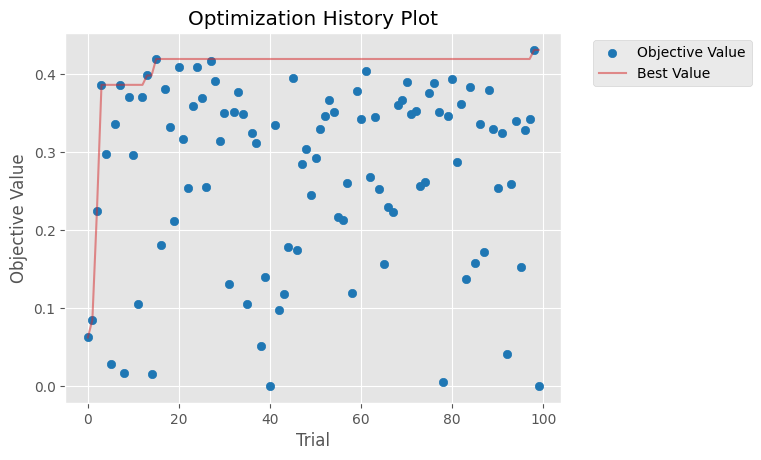

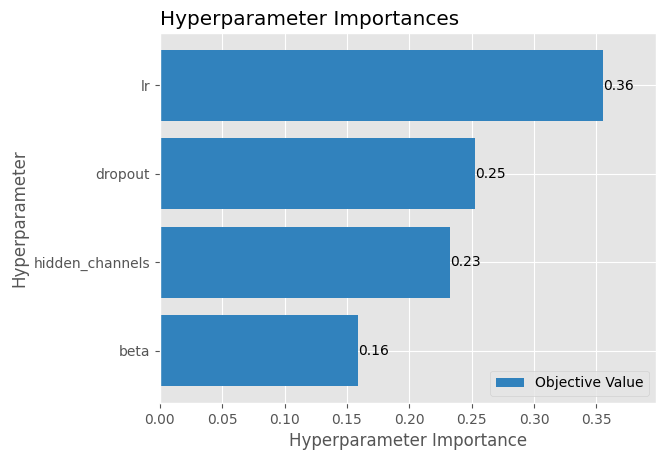

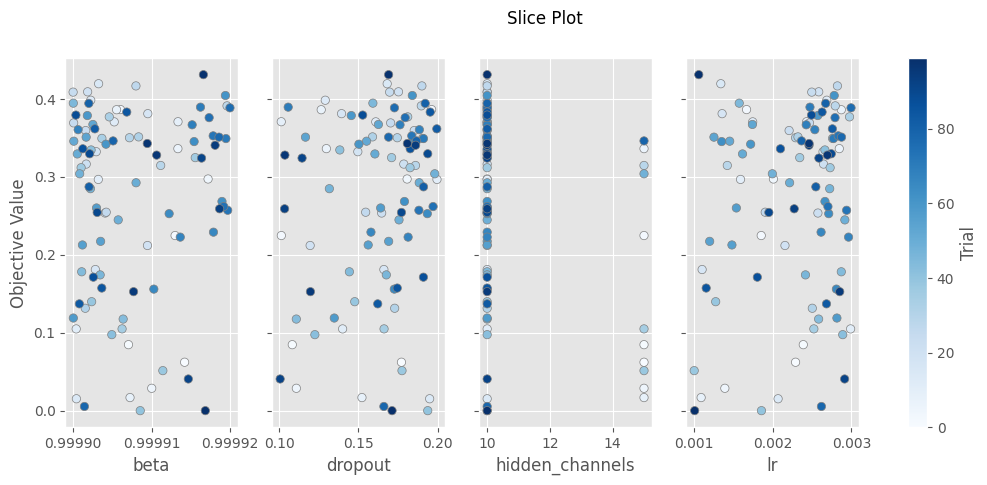

In [41]:
optuna.visualization.matplotlib.plot_optimization_history(study)
optuna.visualization.matplotlib.plot_param_importances(study)
optuna.visualization.matplotlib.plot_slice(study)

In [13]:
from torch_geometric.nn import GCNConv, SAGEConv, GINEConv, GATConv, BatchNorm, Linear
import torch

class GAT_GraphSVX(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_heads, dropout=0.3):
        super(GAT_GraphSVX, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.dropout = dropout
        self.MLP_pre1 = torch.nn.Linear(in_channels, in_channels)
        self.MLP_pre2 = torch.nn.Linear(in_channels, in_channels)
        self.conv1 = GATConv(in_channels, hidden_channels, heads=num_heads, dropout=dropout)
        self.conv2 = GATConv(hidden_channels * num_heads, hidden_channels, heads=num_heads, dropout=dropout)
        self.conv3 = GATConv(hidden_channels * num_heads, hidden_channels, heads=1, concat = False, dropout=dropout)
        self.MLP_post1 = torch.nn.Linear(hidden_channels, hidden_channels)
        self.MLP_post2 = torch.nn.Linear(hidden_channels, out_channels)
        self.log_softmax = torch.nn.LogSoftmax(dim=1)
        self.return_attention_weights = False
    
    def set_return_attention_weights(self, return_attention_weights):
        if return_attention_weights == True or return_attention_weights == False:
            self.return_attention_weights = return_attention_weights
        else:
            raise ValueError('return_attention_weights must be either True or False')


    def forward(self, x, edge_index):
        # Pre processing layers
        x = self.MLP_pre1(x)
        x = self.MLP_pre2(x)
        
        # GNN layers
        x, attention_weights1 = self.conv1(x, edge_index, return_attention_weights=True)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x, attention_weights2 = self.conv2(x, edge_index, return_attention_weights=True)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x, attention_weights3 = self.conv3(x, edge_index, return_attention_weights=True)
        
        # Post processing layers
        x = self.MLP_post1(x)
        x = self.MLP_post2(x)
        
        # Activation function
        x = self.log_softmax(x) #<--- need to use NLLLoss
        
        if self.return_attention_weights:
            return x, attention_weights1, attention_weights2, attention_weights3
        else:
            return x
    
    # Adaption for Node Feature Vector (NFV) input
    def set_test_data(self, testdata):
        self.testdata = testdata
    
    def set_node_to_explain(self, node_to_explain):
        self.node_to_explain = node_to_explain
    
    def forward_NFVinput(self, node_feature_vec):
        print('Starting forward_LIME...')
        num_nodes = self.testdata.x.shape[0]
        
        node_feature_vec = node_feature_vec.reshape(-1,self.in_channels)
        num_samples = node_feature_vec.shape[0]
        out = torch.zeros((num_samples,2))
        print(f'Number of samples = {num_samples}')
        
        data_list = []
        
        print('Loading data...')
        for i in range(num_samples):
            new_graph = copy.deepcopy(self.testdata)
            new_graph.x[self.node_to_explain,:] = node_feature_vec[i,:]
            data_list.append(new_graph)
        print(f'number of graphs = {len(data_list)}')
        
        print('Loading data into a single batch...')
        #dataset = CustomDataset(data_list)
        batch = torch_geometric.data.Batch.from_data_list(data_list)
        
        print('Starting forward pass...')
        with torch.no_grad():
            out_tmp = self.forward(batch.x, batch.edge_index).exp()
        
        print(f'out_tmp.shape = {out_tmp.shape}')
        print('Extracting output...')
        for i in range(batch.num_graphs):
            out[i] = out_tmp[self.node_to_explain+i*num_nodes,:]
            
        print('Finished.')

        return out

In [14]:
def train_GAT_GraphSVX(hyperparameters = None, verbose = False):
    # Computing device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')
    print('Double check which dataset is being used.')
    
    # Data
    traindata = data.AmlsimDataset(node_file='data/simulation3/swedbank/train/nodes.csv', edge_file='data/simulation3/swedbank/train/edges.csv', node_features=True, node_labels=True).get_data()
    testdata = data.AmlsimDataset(node_file='data/simulation3/swedbank/test/nodes.csv', edge_file='data/simulation3/swedbank/test/edges.csv', node_features=True, node_labels=True).get_data()
    traindata = torch_geometric.transforms.ToUndirected()(traindata)
    testdata = torch_geometric.transforms.ToUndirected()(testdata)
    feature_names = ['sum','mean','median','std','max','min','in_degree','out_degree','n_unique_in','n_unique_out']
    target_names = ['not_sar','is_sar']
    
    # --- Add preprocessing here ---
    
    traindata = traindata.to(device)
    testdata = testdata.to(device)
    
    # Non-tunable hyperparameters
    in_channels = traindata.x.shape[1]
    out_channels = 2
    
    # Tunable hyperparamters
    hidden_channels = 10
    num_heads = 3
    dropout = 0.3
    lr = 0.005
    epochs = 400
    class_weights = [1, 3]
    
    class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
    
    # Model
    model = GAT_GraphSVX(in_channels=in_channels,
                        hidden_channels=hidden_channels,
                        out_channels=out_channels,
                        num_heads=num_heads,
                        dropout=dropout)
    
    model = model.to(device)
    
    # Criterion and optimizer
    criterion = torch.nn.NLLLoss(weight=class_weights)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Train model
    print(f'Starting training with {epochs} epochs.')
    # This model needs special input format, so we can't use the train_model function
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model.forward(traindata.x, traindata.edge_index)
        loss = criterion(out, traindata.y)
        loss.backward()
        optimizer.step()
        if verbose and ((epoch+1)%10 == 0 or epoch == epochs-1):
            model.eval()
            with torch.no_grad():
                out = model.forward(testdata.x, testdata.edge_index)
                loss = criterion(out, testdata.y)
                precision = precision_score(testdata.y.cpu().numpy(), out.cpu().numpy().argmax(axis=1), zero_division=0)
                recall = recall_score(testdata.y.cpu().numpy(), out.cpu().numpy().argmax(axis=1), zero_division=0)
                print(f'epoch: {epoch + 1}, loss: {loss:.4f}, precision: {precision:.4f}, recall: {recall:.4f}')
    print('Finished training.')
    
    return model, traindata, testdata, feature_names, target_names

In [15]:
model, traindata, testdata, feature_names, target_names = train_GAT_GraphSVX(verbose=True)

Using device: cuda
Double check which dataset is being used.
Starting training with 400 epochs.
epoch: 10, loss: 27.1826, precision: 0.0682, recall: 0.3770
epoch: 20, loss: 13.0339, precision: 0.1443, recall: 0.3885
epoch: 30, loss: 2.4645, precision: 0.1389, recall: 0.4345
epoch: 40, loss: 10.2796, precision: 0.0893, recall: 0.9954
epoch: 50, loss: 0.8300, precision: 0.0769, recall: 0.1931
epoch: 60, loss: 1.9467, precision: 0.0000, recall: 0.0000
epoch: 70, loss: 1.0454, precision: 0.1062, recall: 0.6782
epoch: 80, loss: 1.0321, precision: 0.0947, recall: 0.9586
epoch: 90, loss: 1.1073, precision: 0.0888, recall: 0.9632
epoch: 100, loss: 0.8257, precision: 0.0910, recall: 0.8437
epoch: 110, loss: 1.0332, precision: 0.0897, recall: 1.0000
epoch: 120, loss: 1.1550, precision: 0.0890, recall: 0.9816
epoch: 130, loss: 0.8288, precision: 0.0922, recall: 0.8414
epoch: 140, loss: 0.8739, precision: 0.0889, recall: 0.8575
epoch: 150, loss: 1.1634, precision: 0.0897, recall: 1.0000
epoch: 160

In [31]:
a = ['account','bank','sum','mean','median','std','max','min','in_sum','out_sum','in_mean','out_mean','in_median','out_median','in_std','out_std','in_max','out_max','in_min','out_min','count_in','count_out','count_days_in_bank','count_phone_changes','sum_spending','mean_spending','median_spending','std_spending','max_spending','min_spending','count_spending','is_sar']
print(len(a ))

32


In [33]:
b = ['account','bank','sum','in_sum','out_sum','mean','in_mean','out_mean','median','in_median','out_median','std','in_std','out_std','max','in_max','out_max','min','in_min','out_min','count_in','count_out','unique_in','unique_out','count_days_in_bank','count_phone_changes','sum_spending','mean_spending','median_spending','std_spending','max_spending','min_spending','count_spending','is_sar']
print(len(b))

34


In [44]:
# Load model from optuna and check results
best_model_path = 'best_model.pkl'
best_model = joblib.load(best_model_path)

from sklearn.metrics import confusion_matrix
import numpy as np

print(best_model == None)

best_model.eval()
with torch.no_grad():
    out = best_model.forward(testdata.x, testdata.edge_index)
    out = F.softmax(out, dim=1)
    y_pred = out.cpu().numpy().argmax(axis=1)
    y_true = testdata.y.cpu().numpy()
    cm = confusion_matrix(y_true, y_pred)
    print(cm)

FPpercent = cm[0,1] / (cm[1,1] + cm[0,1])
print(FPpercent)

# Todo: precision recall curve
precision, recall, thresholds = precision_recall_curve(y_true, out[:,1].cpu().numpy())
average_precision = average_precision_score(y_true, out[:,1].cpu().numpy())

print(f'Average Precision = {average_precision}')

# print(thresholds)
# print(len(thresholds))

plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

True


AttributeError: 'NoneType' object has no attribute 'eval'